<a href="https://colab.research.google.com/github/LucasMeirellesS/LrProject/blob/main/LrProject2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessarias

In [229]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import sys

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split as tts,
                                     cross_validate as cv)
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn import set_config

import warnings

warnings.filterwarnings("ignore")


# Criando Classes

In [230]:
# Criando classe para tratamento de dataframe dataframe
class DataframeModel():
  def __init__(self):
    self.dataframe = None

# Método para carregar o dataframe
  def set_dataframe(self, dataset:str, t="csv"):
    '''
    Atribui um dataframe ao atributo dataframe da classe DataframeModel

    - Parametros:
    dataset: Parâmetro do tipo string. Deve receber o nome ou o caminho do dataset.
    t: Parâmetro do tipo string. Deve receber o tipo do arquivo da base de dados

    Obs: No momento o método funciona apenas para os tipos "csv" e "excel"
    '''
    if t == 'csv':
      self.dataframe = pd.read_csv(dataset)
    elif t == 'excel':
      self.dataframe = pd.read_excel(dataset)


# Método para mostrar o dataframe
  def show(self, head = False, v = 5):
    '''
    Mostra o dataframe atribuido ao atributo dataframe

    - Parametros:
    head:  Recebe um booleano. Se False, será plotado o dataframe completo, se True, aplicará o método head no dataframe.
    v: Recebe um inteiro. Será utilizado como parâmetro para mostrar o número de linhas que será utilizado o método head.

    '''
    if head:
      display(self.dataframe.head(v))
    else:
      display(self.dataframe)


# Método para separar categóricas
  def _get_cat(self, df):
    '''
    Cria uma lista com as colunas categoricas do dataframe da classe. É um método auxiliar do método cat_num.

    - Parametros:
    df: Recebe um dataframe. Esse dataframe será utilizado como base para a obtenção dos nomes das colunas.

    '''
    cat_col = df.select_dtypes(exclude='number').columns.to_list()
    self.cat_col = cat_col
    return cat_col

# Método para separar numéricas
  def _get_num(self, df):
    '''
    Cria uma lista com as colunas numéricas do dataframe da classe. É um método auxiliar do método cat_num.
    - Parametros:
    df: Recebe um dataframe. Esse dataframe será utilizado como base para a obtenção dos nomes das colunas.
    '''
    num_col = df.select_dtypes(include='number').columns.to_list()
    self.num_col = num_col
    return num_col

# Método para executar os métodos para separar categóricas e numericas
  def cat_num(self, target:str):
    '''
    Executa os métodos _get_cat() e _get_num(), criando uma variável,
    atribuindo o dataframe do atributo de classe dataframe sem a coluna a ser utilizada como target.

    -Parametros:
    target: Recebe uma string com o nome da coluna a ser utilizada como target.
    '''
    df = self.dataframe.drop(target, axis=1)
    return self._get_cat(df), self._get_num(df)


# Método para eliminar colunas permanentemente do dataframe da classe
  def drop_column(self, column):
    '''
    Elimina permanentemente uma coluna do dataframe registrado no atributo de classe "dataframe"
    -Parametros:
    column: Recebe uma string com o nome da coluna a ser excluida do dataframe
    '''
    self.dataframe.drop(column, axis = 1, inplace=True)


# Método para verificar algumas informações do dataframe
  def analitics(self):
    '''
    Mostra as informações gerais do dataframe registrado na classe, além da quantidade de valores nulos por coluna
    e a descrição estatística do dataframe.
    '''
    print("Informações gerais do dataframe")
    print(self.dataframe.info())
    print('')
    print('Valores Nulos')
    print(self.dataframe.isna().sum().to_frame().rename(columns={0:"null"}))
    print('')
    print("Descrição estatística")
    print(self.dataframe.describe())


# Método para observar a correlação linear entre a coluna target e as demais colunas
  def get_correlation(self, target:str):
    '''
    Mostra a correlação linear entre a coluna target e as demais colunas do dataframe da classe.
    -Parametros:
    target: Recebe uma string contendo o nome da coluna a ser usada como target.
    '''
    return self.dataframe.corr()[target]


  def get_corr_columns(self, target:str, min_limit=0.65):
    '''
    Retorna as colunas com valor de correlação linear absoluto entre o mínimo selecionado pelo usuário e numeros menores que 1
    em relação à coluna target a ser utilizada no modelo de regressão, o intuito é pegar as colunas com valores relevantes tanto positivos
    quanto negativos.

    -Parametros:
    target: Recebe uma string contendo o nome da coluna a ser usada como target no modelo.
    min_limit: Recebe um float com o valor do limite mínimo menor que 1.
    '''
    correlation = self.get_correlation(target)
    columns = []
    for i in range(0, len(correlation.values)):
      if abs(correlation.values[i]) >= min_limit and correlation.values[i] < 1:
        columns.append(correlation.index[i])
    return columns


# Método para mudar o nome da coluna
  def change_c_name(self, c_name:str, n_name:str):
    '''
    Muda o nome de uma coluna selecionada do dataframe da classe.
    c_name: Recebe uma string com o nome da coluna que será alterada.
    n_name: Recebe uma string com o novo nome da coluna.
    '''
    self.dataframe.rename(columns={c_name:n_name}, inplace=True)

# Método para definir as bases de treino e teste
  def get_train_test(self, x, y):
    '''
    Separa os dados de treino e teste para serem usados no modelo.
    -Parametros:
    x: Recebe uma lista de strings contendo as colunas para os dados x.
    y: Recebe uma string com o nome da coluna target para os dados y.
    '''
    self.x_train, self.x_test, self.y_train, self.y_test = tts(self.dataframe[x], self.dataframe[y], test_size=0.25, random_state=101)



# Criando classe para graficos

In [231]:
class SeabornPlot():

  def __init__(self, data , x , y, title: str, hue:str=None, palette="BuPu"):
    self.data= data
    self.x= x
    self.y= y
    self.title= title
    self.palette=palette
    self.hue=hue
    sns.set_theme(style="whitegrid")

  def barplot(self):
    fig, ax = plt.subplots(figsize=(12,10))
    sns.barplot(data=self.data, x=self.x, y=self.y, ax=ax, palette=self.palette)
    ax.set_xlabel(self.x)
    ax.set_ylabel(self.y)
    ax.set_title(self.title)
    for label in ax.containers:
      ax.bar_label(label)
      plt.legend(loc="upper left")
      plt.show()

  def countplot(self):
    fig, ax = plt.subplots(figsize=(12,10))
    sns.countplot(data=self.data, x=self.x, y=self.y, palette = self.palette, hue=self.hue,  ax=ax)
    ax.set_xlabel(self.x)
    ax.set_ylabel(self.y)
    ax.set_title(self.title)
    for label in ax.containers:
      ax.bar_label(label)
      plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

  def pairplot(self):
    sns.pairplot(data= self.data)
    plt.title(self.title)

  def heatmap(self):
    fig, ax = plt.subplots(figsize=(12,10))
    corr=self.data.corr()
    mask=np.triu(np.ones_like(corr))
    sns.heatmap(data=corr, mask=mask, annot=True, fmt=".1f")
    plt.title(self.title)


## Criando classe para pipeline

In [232]:
# Classe para geração de pipeline
class PipelineClass():

  def __init__(self, model, encoder, scaler, dataframe):
    self.model = model
    self.encoder = encoder
    self.scaler = scaler
    # Obs: O dataframe utilizado é uma instância da classe DataframeModel
    self.dataframe = dataframe

# Método para criar o preprocessing
  def preprocessing(self):
    '''
    Método para o preprocessamento de dados categoricos e numéricos dos dados do dataframe de uma instância da classe DataFrameModel.
    Esse método utiliza a função ColumnTransformer do scikitlearn e atribui o retorno dessa função ao atributo preprocessing.
    '''
    self.preprocessing=ColumnTransformer([
      ("scaler", self.scaler, self.dataframe.num_col),
      ("encoder", self.encoder, self.dataframe.cat_col)
    ])


# Método para gerar o pipeline
  def get_pipeline(self):
    '''
    Método que instancia um pipeline para ser usado no modelo com a função Pipeline do scikitlearn, atribuindo esse resultado ao atributo de classe pipeline.
    '''
    self.pipeline=Pipeline([
      ("preprocessing", self.preprocessing),
      #("imputer",SimpleImputer(missing_values=np.nan, strategy="median")),
      ("pca",PCA(n_components=4)),
      ("model", self.model)
    ])


# Método para treinar o pipeline
  def fit_pipe(self):
    '''
    Método que treina o pipeline criando pelo método get_pipeline().
    '''
    self.pipeline.fit(self.dataframe.x_train, self.dataframe.y_train)


# Método para ajustar o modelo
  def set_model(self, model):
    '''
    Método para alterar o atributo de classe model com um modelo diferente.
    '''
    self.model = model


# Método para a geração de métricas de avaliação do modelo
  def get_metrics(self, test=True, x= None, y= None):

    '''
    Cria um dicionário com as métricas de avaliação calculadas após treinar o pipeline.
    -Parametros:
    # Provisório
    test: Recebe um booleano. Se True, utiliza os dados de teste do objeto DataFrameModel, se false, utiliza outros dados de x e y
    x: Recebe os dados x a serem utilizados no modelo.
    y: Recebe os dados y a serem utilizados no modelo.
    '''
    if test:
      y_pred = self.pipeline.predict(self.dataframe.x_test)

      model_metrics = {
        'MAE': metrics.mean_absolute_error(self.dataframe.y_test, y_pred),
        'MSE': metrics.mean_squared_error(self.dataframe.y_test, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(self.dataframe.y_test, y_pred)),
        'R2': metrics.r2_score(self.dataframe.y_test, y_pred),
      }
      return model_metrics

    elif test == False and x is not None and y is not None:
      y_pred = self.pipeline.predict(x)

      model_metrics = {
        'MAE': metrics.mean_absolute_error(y, y_pred),
        'MSE': metrics.mean_squared_error(y, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y, y_pred)),
        'R2': metrics.r2_score(y, y_pred),
      }
      return model_metrics

# Método para a realização do Cross Validation
  def cross_validation(self, model_dict:dict):
    '''
    Faz um cross validation de vários modelos a partir de um dicionário de modelos.
    -Parametros:
    model_dict: Recebe um dicionário de vários modelos para serem utilizados no cross validation.
    '''
    results = []

    for model_name, modelo in models.items():
      pipe.pipeline.set_params(model=modelo).fit(self.dataframe.x_train, self.dataframe.y_train)
      result=pipe.get_metrics()
      results.append(result)

    df_results=pd.DataFrame(results).T
    df_results.columns=list(models.keys())
    return df_results.round(2)


In [233]:
df=pd.read_csv("/content/C├│pia de CarPrice_Assignment.csv")


# Testando Classes

## Testando graficos

In [234]:
df=pd.read_csv("/content/C├│pia de CarPrice_Assignment.csv")

In [235]:
df.head(1)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0


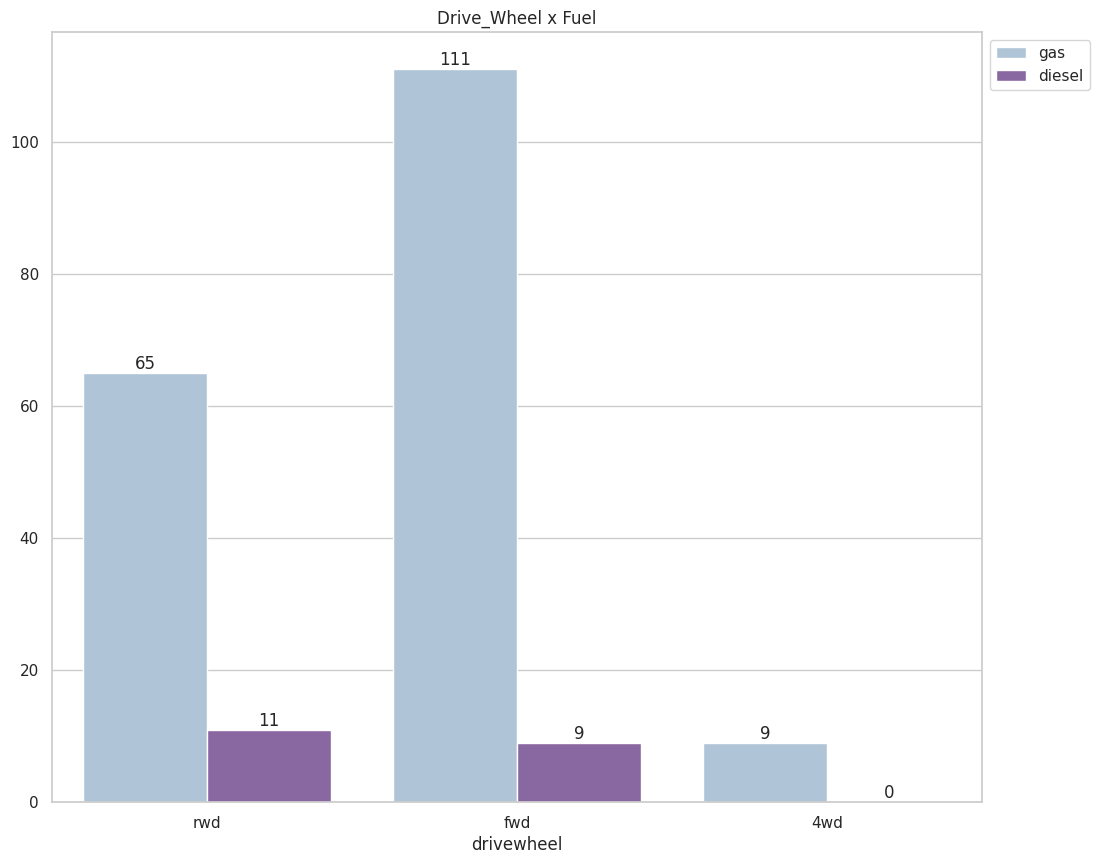

In [236]:
count=SeabornPlot(data=cars.dataframe, x="drivewheel", y=None, hue="fueltype", title="Drive_Wheel x Fuel")
count.countplot()

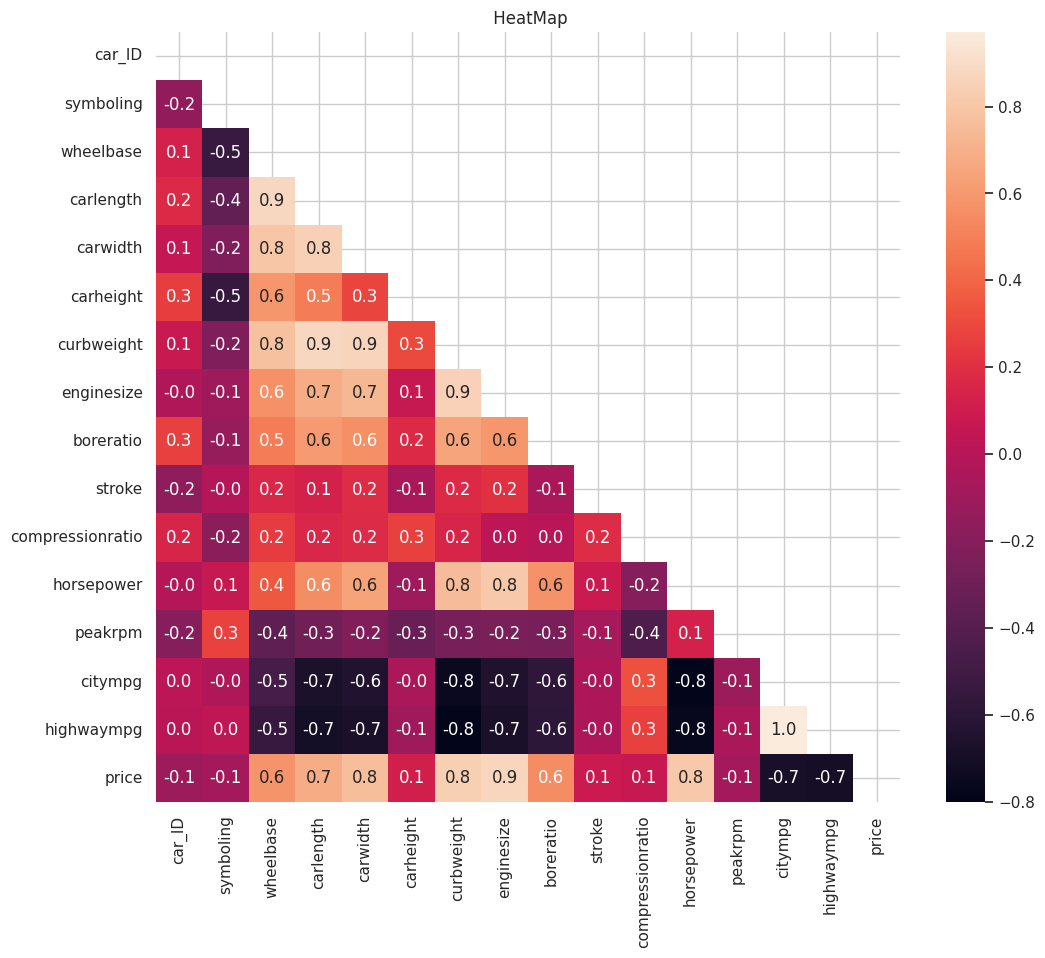

In [237]:
heat=SeabornPlot( data= df, x=None, y=None, title=" HeatMap", hue=None)
heat.heatmap()

In [238]:
#pair=SeabornPlot(data=df, x=None, y=None, title="PairPlot", hue=None)
#pair.pairplot()

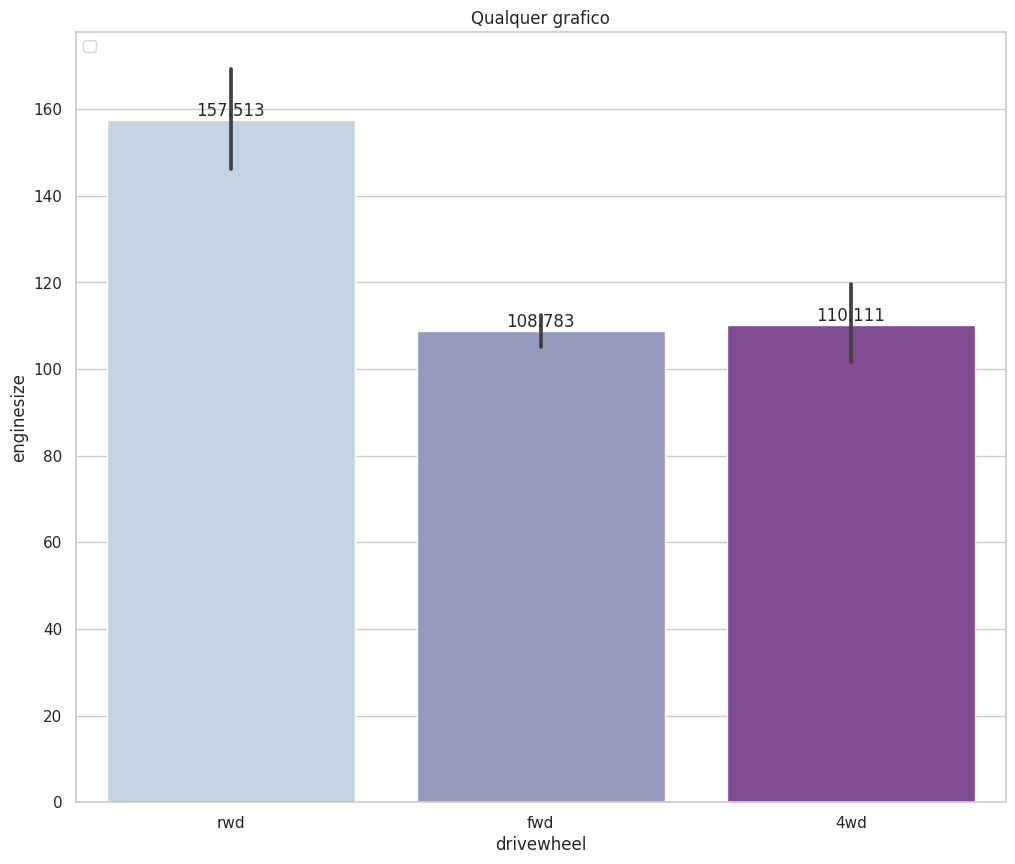

In [239]:
plot=SeabornPlot(data=df, y="enginesize", x="drivewheel", title="Qualquer grafico" )
plot.barplot()

## Instanciando classe

In [240]:
# Instânciando classe
cars = DataframeModel()
cars.set_dataframe(dataset='/content/C├│pia de CarPrice_Assignment.csv')
cars.show(True)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


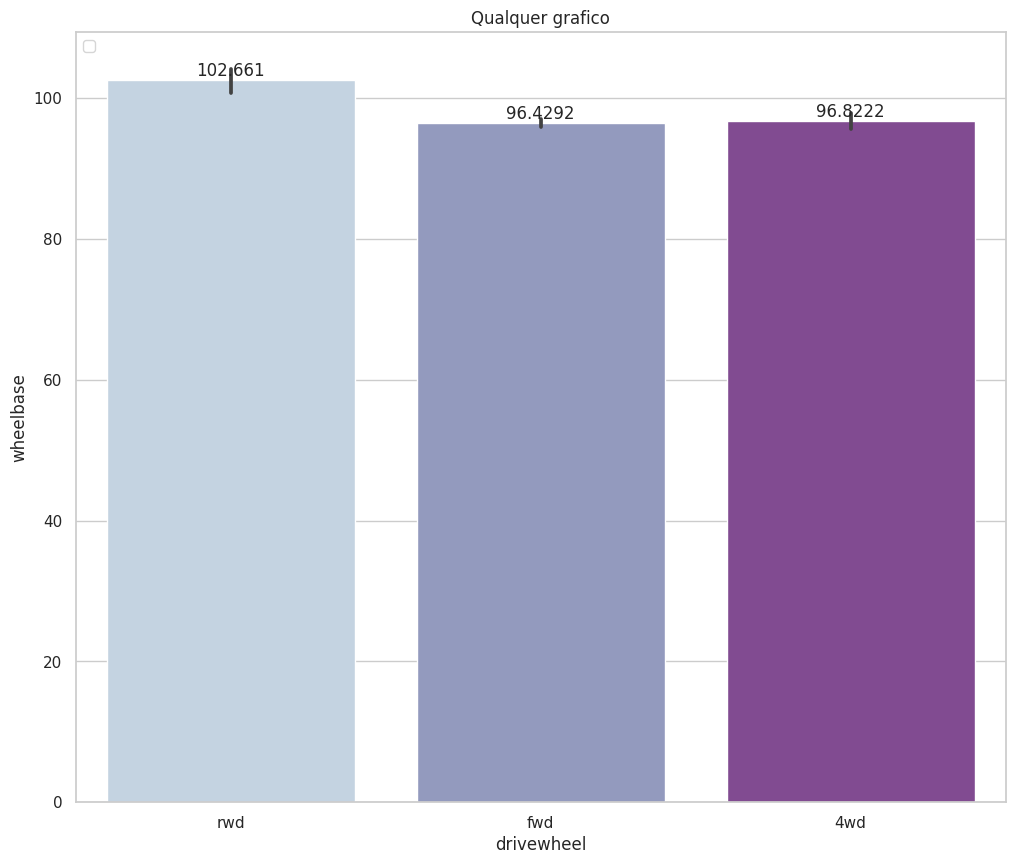

In [241]:
#Erro que aconteceu utilizando importacao usanod CLASSE

plot =SeabornPlot(data=cars.dataframe, y="wheelbase", x="drivewheel", title="Qualquer grafico" )
plot.barplot()

In [242]:
# Analisando as informações do dataframe
cars.analitics()

Informações gerais do dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize  

In [243]:
# Eliminando permanentemente a coluna car_ID do atributo dataframe da classe
cars.drop_column('car_ID')

In [244]:
# Definindo colunas categoricas e numéricas
cat, num = cars.cat_num('price')

In [245]:
# Observando categóricas
cat

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [246]:
df=pd.read_csv("/content/C├│pia de CarPrice_Assignment.csv")

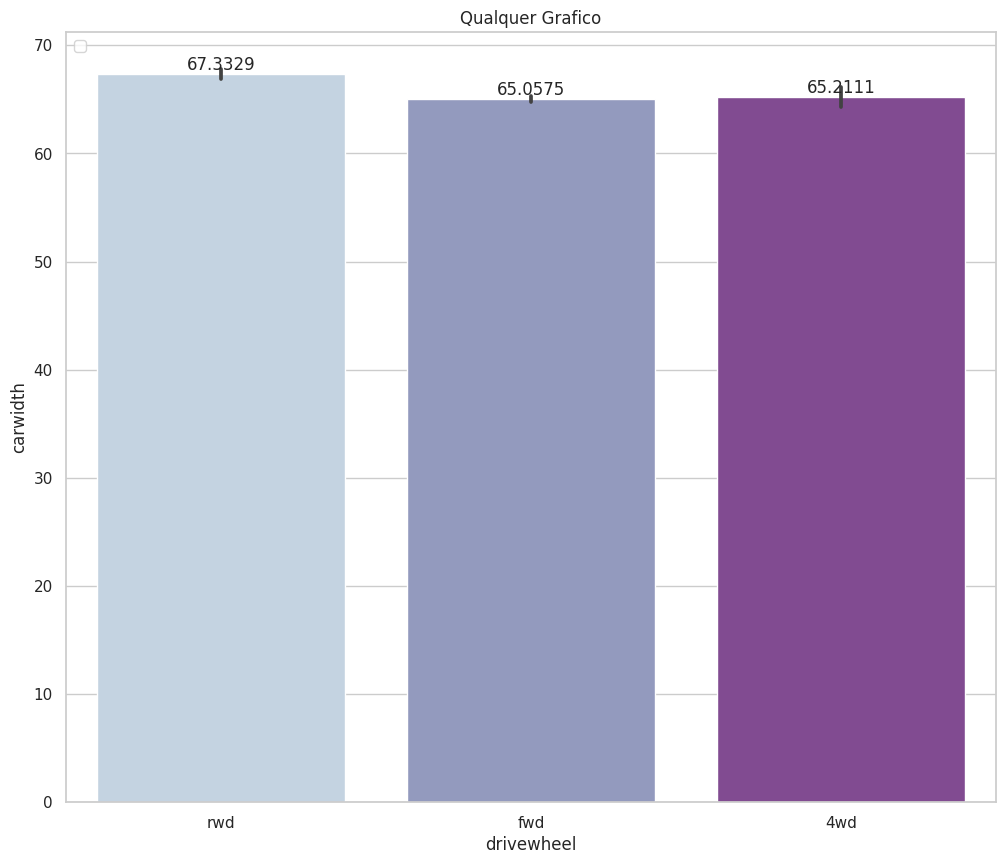

In [247]:
plotter=SeabornPlot(data=cars.dataframe, x="drivewheel", y="carwidth", title="Qualquer Grafico")
plotter.barplot()


In [248]:
cars.analitics()

Informações gerais do dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem  

In [249]:
cat_col=df.select_dtypes(exclude="number").columns

In [250]:
# Observando numéricas
num

['symboling',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

In [251]:
# Definindo x e y
x = cat + num
y = 'price'

In [252]:
cars.get_correlation('price')

symboling          -0.079978
wheelbase           0.577816
carlength           0.682920
carwidth            0.759325
carheight           0.119336
curbweight          0.835305
enginesize          0.874145
boreratio           0.553173
stroke              0.079443
compressionratio    0.067984
horsepower          0.808139
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
price               1.000000
Name: price, dtype: float64

In [253]:
cars.get_corr_columns('price')

['carlength',
 'carwidth',
 'curbweight',
 'enginesize',
 'horsepower',
 'citympg',
 'highwaympg']

In [254]:
# Selecionando as bases de treino e teste
cars.get_train_test(x, y)

In [255]:
# Instanciando pipeline para avaliar as métricas do LinearRegression
scaler = StandardScaler()
encoder = OneHotEncoder(drop='if_binary', handle_unknown = 'ignore', sparse_output=False)
model = LinearRegression()
pipe = PipelineClass(model, encoder, scaler, cars)

# Rodando o método para pre-processamento de coluna
pipe.preprocessing()
# Criando pipeline
pipe.get_pipeline()
# Treinando pipeline
pipe.fit_pipe()
# Calculando métricas
pipe.get_metrics()

{'MAE': 3015.0372207880214,
 'MSE': 18498122.714085944,
 'RMSE': 4300.944397930058,
 'R2': 0.7393522812002506}

In [256]:
# Criando dicionário de modelos para cross validation
models = {
      'lr': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gbc': RandomForestRegressor(),
     "ada": AdaBoostRegressor()}

# Calculando Cross Validation
pipe.cross_validation(models)


,lr,rf,gbc,ada
MAE,3015.04,1975.39,1999.30,1870.76
MSE,18498122.71,10464612.10,10622869.99,9746943.79
RMSE,4300.94,3234.91,3259.27,3122.01
R2,0.74,0.85,0.85,0.86
